# Backwards-facing step channel (Stokes)

All the information about the problem is contained in a *case* object. To create such a case object, call the `backstep` function.

In [1]:
%matplotlib inline

In [2]:
from bbflow.cases.backstep import backstep
case = backstep()

project > constrained 500/7688 dofs, error 0.00e+00/area
project > solving system > solving system using sparse direct solver
project > constrained 5206/7688 dofs, error 0.00e+00/area
  In /home/eivindf/work/nutils/nutils/function.py:2090


The `plot_domain()` method will make a plot of the reference domain. As you can see, it consists of three unit squares, and doesn't look very much like what you might expect.

elem_eval > created ndarray(170100,2)


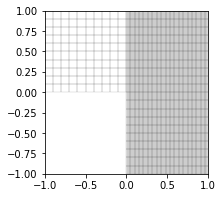

domain012.png


In [3]:
case.plot_domain(show=True, figsize=(10,3))

To plot an actual physical domain (not the reference domain) we need a *parameter value*. Call `parameter()` to get such a value. Without any arguments, this function returns a suitable default. In this case, a height of 1.0 and a length of 10.0.

elem_eval > created ndarray(170100,2)


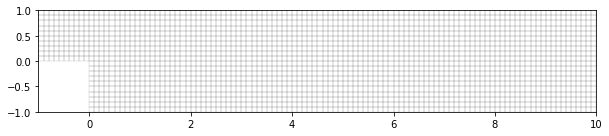

domain013.png


In [4]:
case.plot_domain(case.parameter(), show=True, figsize=(10,3))

The backwards-facing step channel by default ships with four parameters. In order, they are inverse viscosity, channel length, step height and maximal inlet speed. In many cases it may be desirable to focus on a subset of parameters. For this, it's possible to restrict some of the parameters to fixed values.

elem_eval > created ndarray(170100,2)


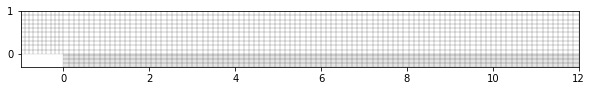

domain014.png


In [5]:
case.restrict(height=0.3)
case.plot_domain(case.parameter(length=12), show=True, figsize=(10,3))

For now, let's keep the full parameter space.

In [6]:
case.restrict(height=None)

Let us solve the Stokes problem for the default parameter value. The `solvers` module contains a `stokes` function for this purpose. It needs nothing other than the case object and the parameter value.

In [7]:
from bbflow.solvers import stokes
mu = case.parameter()
lhs = stokes(case, mu)

solving system > solving system using sparse direct solver
took 1.33e+01 seconds


Matrices and vectors are cached when integrated, so a second solution will not take as long, even with a different parameter value. (The affine decomposition makes sure of that.)

In [8]:
mu = case.parameter(20, 12, 2, 1.2)
lhs = stokes(case, mu)

solving system > solving system using sparse direct solver
took 9.54e-01 seconds


You can plot this solution using the `plots` function in the same module.

elem_eval > created ndarray(170100,2), ndarray(170100,2), ndarray(170100), ndarray(170100)


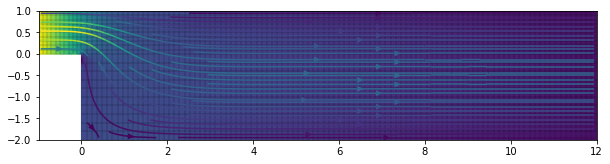

solution-vp000.png


In [9]:
from bbflow.solvers import plots
plots(case, mu, lhs, fields='vp', show=True, figsize=(10,3))

Since Nutils can produce a lot of information in stdout, let's reduce verbosity somewhat.

In [10]:
import nutils.core as core
core.globalproperties['verbose'] = 3

The `solvers` module has a Navier-Stokes solver, too. As might be expected, it is quite a bit slower. This time, the runtime is mostly due to integration inside the Newton loop, which in the high-fidelity case cannot be cached.

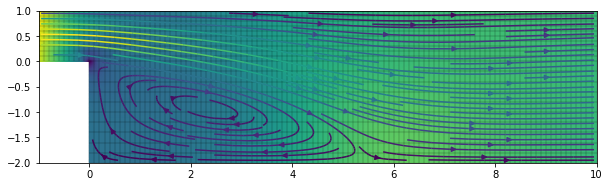

solution-vp000.png


In [11]:
from bbflow.solvers import navierstokes
mu = case.parameter(50, 10, 2, 1.2)
lhs = navierstokes(case, mu)
plots(case, mu, lhs, fields='vp', show=True, figsize=(10,3))

To create an ensemble of solutions sampled at various parameter values, we need a quadrature rule. This is just an iterator of parameter values and weights. The `make_ensemble` function then computes solutions in parallel. Let's create a small one with 256 snapshots (256 = 4^4).

In [12]:
import bbflow.quadrature as quad
from bbflow.ensemble import make_ensemble
scheme = list(quad.full(case.ranges(), 4))
ensemble = make_ensemble(case, stokes, scheme, weights=True)
ensemble.shape

generating ensemble of 256 solutions


(256, 7688)

The `weights` argument determines whether the solutions will be scaled according to the quadrature weights. The ensemble object itself is just a matrix of solution vectors, so we can plot these, too. Just remember to undo the weight scaling if applicable.

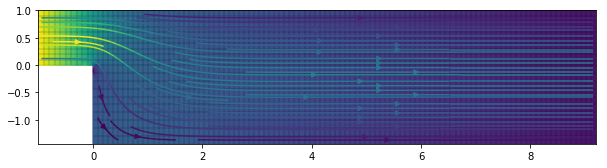

solution-vp000.png


In [13]:
mu, weight = scheme[9]
mu = case.parameter(*mu)
plots(case, mu, ensemble[9] / weight, fields='vp', show=True, figsize=(10,3))

To proceed, we need to perform an eigenvalue analysis of this ensemble.

In [14]:
from bbflow.reduction import eigen
decomp = eigen(case, ensemble)

The `plot_spectrum` function can help us visualize the eigenvalue decay.

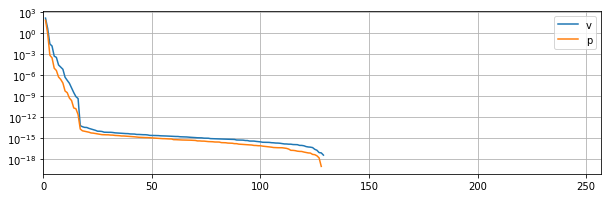

spectrum000.png


In [15]:
from bbflow.reduction import plot_spectrum
plot_spectrum(decomp, show=True, figsize=(10,3))

For the Stokes solutions, the decay is extremely rapid. Probably this has something to do with the fact that two of the parameters (inflow speed and viscosity) have trivial effects on the solution.

To create a reduced basis, we call the `reduce` function. It needs an error threshold or a number of modes to accept (both of them either global or specified per field).

In [16]:
from bbflow.reduction import reduce
projection, lengths = reduce(case, ensemble, decomp, threshold=1e-6)
projection.shape

v: 16 modes suffice for 0.00e+00 error (threshold 1.00e-06)
p: 13 modes suffice for 7.19e-07 error (threshold 1.00e-06)


(29, 7688)

It returns a projection matrix and a list of basis lengths. You can use the projection matrix the same way as you do an ensemble, and plot the basis functions. Note that these functions are meant to approximate the solution minus the lift, therefore, depending on the lift used, they may not resemble actual solutions.

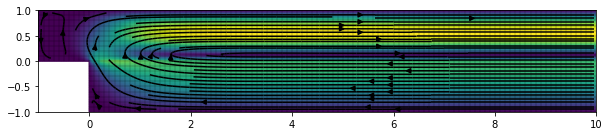

solution-v000.png


In [17]:
plots(case, case.parameter(), projection[0], fields='v', lift=False, show=True, figsize=(10,3))

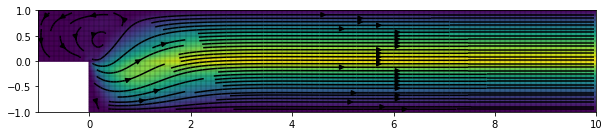

solution-v000.png


In [18]:
plots(case, case.parameter(), projection[1], fields='v', lift=False, show=True, figsize=(10,3))

We can then create a reduced basis representation of the original case object. This requires some time because it needs to integrate the reduced convection tensors, which are not cached from the high-fidelity solutions.

In [19]:
from bbflow.cases import ProjectedCase
projcase = ProjectedCase(case, projection, lengths)

And finally, let us solve the same problem with the high-fidelity solver and the reduced one.

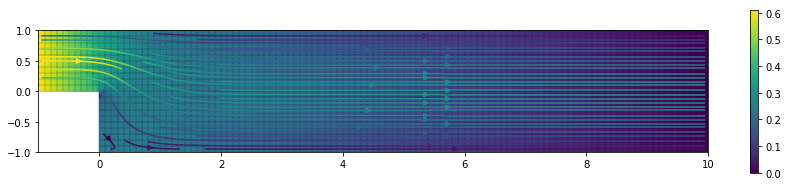

full-vp000.png


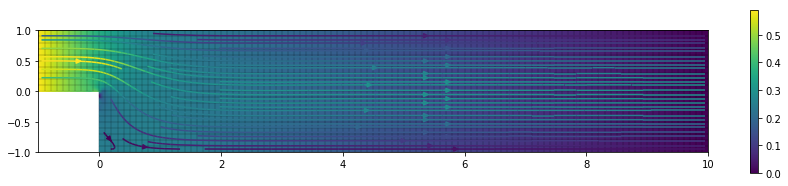

reduced-vp000.png


In [20]:
mu = case.parameter()
lhs = stokes(case, mu)
plots(case, mu, lhs, fields='vp', plot_name='full', colorbar=True, show=True, figsize=(15,3))
lhs = stokes(projcase, mu)
plots(projcase, mu, lhs, fields='vp', plot_name='reduced', colorbar=True, show=True, figsize=(15,3))